In [1]:
from tqdm import tqdm
from workflow.fastani.remove_gunc_failed_contigs_by_contamination_sp_cluster import RemoveGuncFailedContigsByContaminationSpCluster
from workflow.config import PCT_VALUES
from workflow.external.gtdb_metadata import GtdbMetadataR207Full, GtdbMetadataR207
from workflow.external.gtdb_sp_clusters import GtdbSpClustersR207
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from workflow.fastani.run_fastani_on_interspecies_aggregate import RunFastAniOnInterspeciesAniAggregate


In [2]:
DF_SP = GtdbSpClustersR207().output().read_cached()
DF_SP.head()

,rep_genome,taxonomy,ani_radius,ani_mean,ani_min,af_mean,af_min,n_genomes
species,,,,,,,,
s__0-14-0-10-38-17 sp002774085,GB_GCA_002774085.1,d__Bacteria;p__Patescibacteria;c__Microgenomat...,95.0,NaN,NaN,NaN,NaN,1
s__0-14-0-20-30-16 sp002779075,GB_GCA_002779075.1,d__Archaea;p__Iainarchaeota;c__Iainarchaeia;o_...,95.0,NaN,NaN,NaN,NaN,1
s__0-14-0-20-30-16 sp903916665,GB_GCA_903916665.1,d__Archaea;p__Iainarchaeota;c__Iainarchaeia;o_...,95.0,NaN,NaN,NaN,NaN,1
s__0-14-0-20-34-12 sp002779065,GB_GCA_002779065.1,d__Archaea;p__Iainarchaeota;c__Iainarchaeia;o_...,95.0,NaN,NaN,NaN,NaN,1
s__0-14-0-20-40-13 sp002774285,GB_GCA_002774285.1,d__Bacteria;p__Patescibacteria;c__WWE3;o__0-14...,95.0,NaN,NaN,NaN,NaN,1


In [3]:
DF_ANI = RunFastAniOnInterspeciesAniAggregate().output().read_cached()

In [4]:
DF_ANI.head()

,genus,query,reference,ani,af
0,g__Mycoplasma,GCF_000012765.1,GCF_000012765.1,100.0000,1.000000
1,g__Mycoplasma,GCA_000011445.1,GCF_000012765.1,91.0675,0.782738
2,g__Mycoplasma,GCA_000011445.1,GCA_000011445.1,100.0000,0.992556
3,g__Mycoplasma,GCF_000327395.1,GCF_000012765.1,88.3621,0.834416
4,g__Mycoplasma,GCF_000327395.1,GCA_000011445.1,88.7725,0.824675


In [5]:
DF_ANI = DF_ANI[(DF_ANI['query'] != DF_ANI['reference']) & (DF_ANI['af'] >= 0.5)]

In [6]:
DF_ANI.head()

,genus,query,reference,ani,af
1,g__Mycoplasma,GCA_000011445.1,GCF_000012765.1,91.0675,0.782738
3,g__Mycoplasma,GCF_000327395.1,GCF_000012765.1,88.3621,0.834416
4,g__Mycoplasma,GCF_000327395.1,GCA_000011445.1,88.7725,0.824675
6,g__Mycoplasma,GCF_000224105.1,GCF_000012765.1,79.9475,0.527076
7,g__Mycoplasma,GCF_000224105.1,GCA_000011445.1,79.4262,0.541516


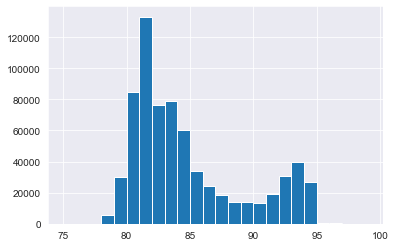

In [7]:

plt.hist(DF_ANI['ani'], bins=list(range(75, 100)))
plt.rcParams['svg.fonttype'] = 'none'
plt.grid(True)
plt.savefig('/tmp/cumani.svg')

In [8]:
DF_ANI['ani'].min(), DF_ANI['ani'].max()

(76.4139, 97.08)

In [9]:
from collections import defaultdict

# What is the the % of interspeices ani > 90 in each genera?

def get_data():
    d_genus_above = defaultdict(lambda: 0)
    d_genus_below = defaultdict(lambda: 0)
    for genus, row in DF_ANI.iterrows():

        if row['ani'] > 95:
            d_genus_above[genus] += 1
        else:
            d_genus_below[genus] += 1

    return d_genus_below, d_genus_above

d_genus_below, d_genus_above = get_data()



273983


(array([2.73616e+05, 7.20000e+01, 1.10000e+02, 7.70000e+01, 0.00000e+00,
        5.50000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.30000e+01]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <BarContainer object of 10 artists>)

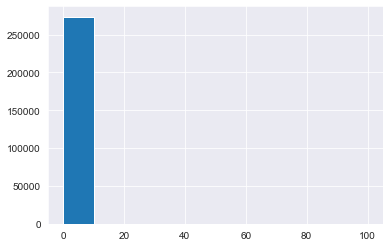

In [10]:
values = list()
for genus in set(d_genus_below.keys()).union(set(d_genus_above.keys())):
    n_total = d_genus_below.get(genus, 0) + d_genus_above.get(genus, 0)
    pct = d_genus_above.get(genus, 0) / n_total * 100
    values.append(pct)

print(len(values))

plt.hist(values, bins=range(0, 110, 10))

In [16]:
print(len(DF_ANI[DF_ANI['ani'] >= 93]))
round(len(DF_ANI[DF_ANI['ani'] >= 93]) / len(DF_ANI) * 100, 2)

67644


9.6